# **DAICOW 2023 Hands-on Tutorial: Radiology Prostate**

In the following tutorial, we will give you a hands-on example for Continual Learning in Radiology. We will start with showing samples of data drifts with sample visualizations and plots for the performance impact. Then in the second part we will evaluate the performance improvements from using methods for Continual Learning. But let's first run this code to initialize our environment. Before running it, please make sure that you are using this code in a GPU environment. You can check this at the performance button (RAM, DISK etc.) on the top right. It should show "T4" if you are connected to a GPU. Else please click it to change the environment.

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet
import os
os.environ['SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL'] = 'True'
%pip install -r requirements.txt
%cd /content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet
import os
os.environ['nnUNet_raw_data_base'] = 'data/raw_data/'
os.environ['nnUNet_preprocessed'] = 'data/preprocessed/'
os.environ['RESULTS_FOLDER'] = 'data/results/'
os.environ['EVALUATION_FOLDER'] = 'data/evaluation/'
os.environ['PARAM_SEARCH_FOLDER'] = ''

# **Part 1:** Data Drift in Radiology

In this section we will show how data drift looks like in radiology by first giving sample images and then showing the performance impact of these drifts.

# Visualize all Sample Images
Run the following visualization code to get samples of data drift in radiology. In the next section we will be training sequentially on data from the datasets visualized in the following images:

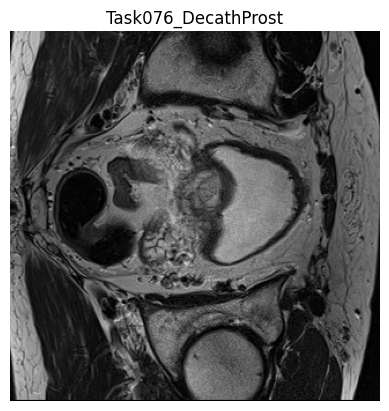

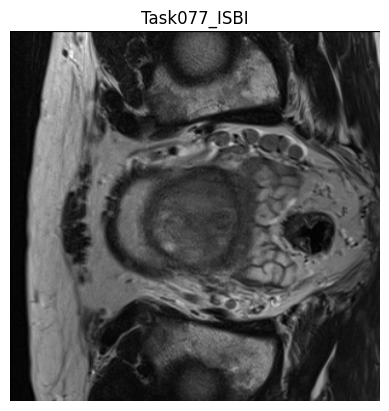

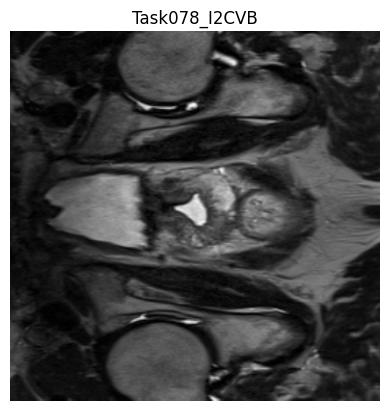

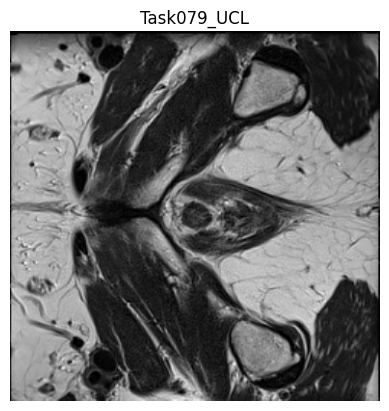

In [2]:
import random
import nibabel as nib
import matplotlib.pyplot as plt
import os

#Visualize all Sample Images
data_76_DecathProst = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/raw_data/nnUNet_raw_data/Task076_DecathProst/imagesTr/'
DecathProst_image = os.path.join(data_76_DecathProst, random.choice([f for f in os.listdir(data_76_DecathProst) if f.endswith('.nii.gz')]))
plt.imshow(nib.load(DecathProst_image).get_fdata()[..., random.randint(0, nib.load(DecathProst_image).shape[-1])], cmap='gray')
plt.axis('off')
plt.title('Task076_DecathProst')
plt.show()

data_77_ISBI = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/raw_data/nnUNet_raw_data/Task077_ISBI/imagesTr/'
ISBI_image = os.path.join(data_77_ISBI, random.choice([f for f in os.listdir(data_77_ISBI) if f.endswith('.nii.gz')]))
plt.imshow(nib.load(ISBI_image).get_fdata()[..., random.randint(0, nib.load(ISBI_image).shape[-1])], cmap='gray')
plt.axis('off')
plt.title('Task077_ISBI')
plt.show()

data_78_I2CVB = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/raw_data/nnUNet_raw_data/Task078_I2CVB/imagesTr'
I2CVB_image = os.path.join(data_78_I2CVB, random.choice([f for f in os.listdir(data_78_I2CVB) if f.endswith('.nii.gz')]))
plt.imshow(nib.load(I2CVB_image).get_fdata()[..., random.randint(0, nib.load(I2CVB_image).shape[-1])], cmap='gray')
plt.axis('off')
plt.title('Task078_I2CVB')
plt.show()

data_79_UCL = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/raw_data/nnUNet_raw_data/Task079_UCL/imagesTr'
UCL_image = os.path.join(data_79_UCL, random.choice([f for f in os.listdir(data_79_UCL) if f.endswith('.nii.gz')]))
plt.imshow(nib.load(UCL_image).get_fdata()[..., random.randint(0, nib.load(UCL_image).shape[-1])], cmap='gray')
plt.axis('off')
plt.title('Task079_UCL')
plt.show()

# Performance Drop from Data Shift
Now we will show the performance impact from the data drifts on the model. First we already trained the model on the first task (76/DecathProst) without any method for Continual Learning. To save you the extensive training time, we commented out the training command and stored the resulting model.
Therefore, you can directly run the evaluation command that will evaluate a model, that was trained only on the first task (76/DecathProst), on all tasks. It takes approx. 400 seconds:

In [3]:
#nnUNet_train_multihead 3d_fullres -t 76 77 78 79 -num_epoch 200 -save_interval 25 -s seg_outputs --store_csv -f 0 -d 0 Pretrained models are already available in the mounted Google Drive
!nnUNet_evaluate 3d_fullres nnUNetTrainerMultiHead -trained_on 76 77 78 79 -f 0 -use_model 76 -evaluate_on 76 77 78 79 70 -d 0 --store_csv



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Loading trainer and setting the network for evaluation
2023-10-10 15:43:34.119780: Using dummy2d data augmentation
Updating the Loss based on the provided previous trainer
2023-10-10 15:43:39.675171: loading checkpoint data/results/nnUNet_ext/3d_fullres/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/Task076_DecathProst/nnUNetTrainerMultiHead__nnUNetPlansv2.1/Generic_UNet/SEQ/fold_0/model_final_checkpoint.model train= False
/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/nnunet_ext/evaluation/evaluator.py:212: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future

After running this evaluation, let's visualize the resulting performance. Note: Task 76/DecathProst is the joint dataset that contains all these datasets.


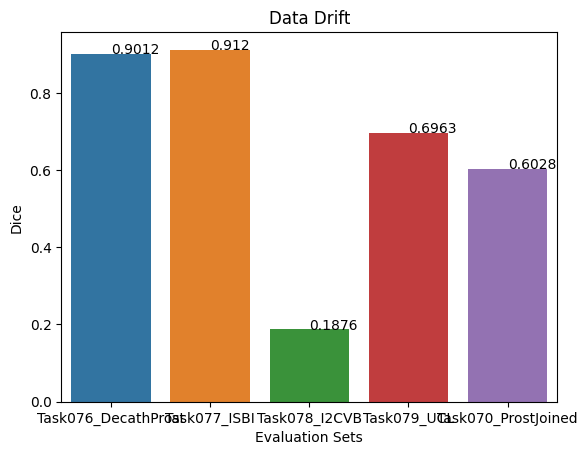

In [4]:
from eval_util import get_dice_vals
import seaborn as sns
import matplotlib.pyplot as plt
eval_folder = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/evaluation/nnUNet_ext/3d_fullres/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/Task076_DecathProst/nnUNetTrainerMultiHead__nnUNetPlansv2.1/Generic_UNet/SEQ/corresponding_head/fold_0/summarized_val_metrics.csv'
tasks = ['Task076_DecathProst', 'Task077_ISBI', 'Task078_I2CVB', 'Task079_UCL', 'Task070_ProstJoined']

tasks, dices = get_dice_vals(tasks, eval_folder)
# Create a bar plot using Seaborn
sns.barplot(x=tasks, y=dices)

# Add labels and title
plt.xlabel('Evaluation Sets')
plt.ylabel('Dice')
for i in range(len(tasks)):
        plt.text(i,dices[i],dices[i])
plt.title('Data Drift')

# Show the plot
plt.show()

# **Part 2:** Continual Learning Methods
In the following, we show the performance in a sequential scenario where we train on all tasks sequentially:
1.   Task 76: DecathProst
2.   Task 77: ISBI
3.   Task 78: I2CVB
4.   Task 79: UCL

We plot the final evaluation performance of each dataset individually after training all these datasets in the given order.





# Training and Evaluation without Method for Continual Learning
We start with training without using any method for Continual Learning (we already did this for you) and evaluate it on all datasets as well as the joint dataset (70). It takes approx. 350 seconds:

In [5]:
#nnUNet_train_multihead 3d_fullres -t 76 77 78 79 -num_epoch 200 -save_interval 25 -s seg_outputs --store_csv -f 0 -d 0 Pretrained models are already available in the mounted Google Drive
!nnUNet_evaluate 3d_fullres nnUNetTrainerMultiHead -trained_on 76 77 78 79 -f 0 -use_model 76 77 78 79 -evaluate_on 76 77 78 79 70 -d 0 --store_csv



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Loading trainer and setting the network for evaluation
2023-10-10 15:51:19.323043: Using dummy2d data augmentation
Updating the Loss based on the provided previous trainer
2023-10-10 15:51:27.216000: loading checkpoint data/results/nnUNet_ext/3d_fullres/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/nnUNetTrainerMultiHead__nnUNetPlansv2.1/Generic_UNet/SEQ/fold_0/model_final_checkpoint.model train= False
/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/nnunet_ext/evaluation/evaluator.py:212: FutureWarning: The frame.append method is deprecated and 

After running this evaluation on the model that was trained without any method for Continual Learning, let's visualize the resulting performance. Note: Task 76/DecathProst is the joint dataset that contains all these datasets.

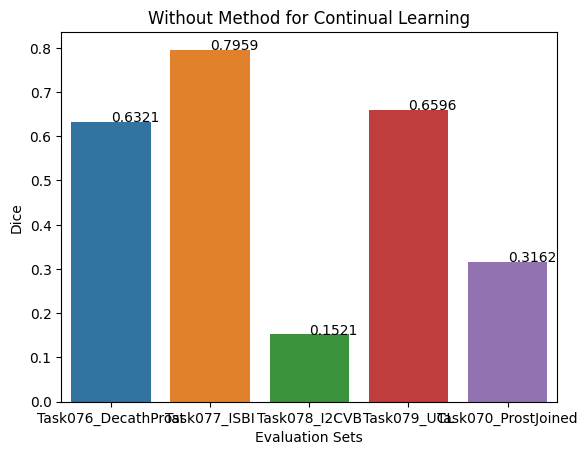

In [7]:
from eval_util import get_dice_vals
import seaborn as sns
import matplotlib.pyplot as plt
eval_folder = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/evaluation/nnUNet_ext/3d_fullres/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/nnUNetTrainerMultiHead__nnUNetPlansv2.1/Generic_UNet/SEQ/corresponding_head/fold_0/summarized_val_metrics.csv'
tasks = ['Task076_DecathProst', 'Task077_ISBI', 'Task078_I2CVB', 'Task079_UCL', 'Task070_ProstJoined']

tasks, dices = get_dice_vals(tasks, eval_folder)
# Create a bar plot using Seaborn
sns.barplot(x=tasks, y=dices)

# Add labels and title
plt.xlabel('Evaluation Sets')
plt.ylabel('Dice')
for i in range(len(tasks)):
        plt.text(i,dices[i],dices[i])
plt.title('Without Method for Continual Learning')

# Show the plot
plt.show()

# Training and Evaluation with EWC:
Now we use the method Elastic Weight Consolidation (EWC) for training(already done) and evaluate all datasets on the resulting model. It takes approx. 300 seconds:

In [ ]:
#nnUNet_train_ewc 3d_fullres -t 76 77 78 79 -ewc_lambda 0.4 -num_epoch 200 -save_interval 25 -s seg_outputs --store_csv -f 0 -d 0 Pretrained models are already available in the mounted Google Drive
!nnUNet_evaluate 3d_fullres nnUNetTrainerEWC -trained_on 76 77 78 79 -f 0 -use_model 76 77 78 79 -evaluate_on 76 77 78 79 70 -d 0 --store_csv

After running this evaluation on the model that was trained using EWC, let's visualize the resulting performance. Note: Task 76/DecathProst is the joint dataset that contains all these datasets.

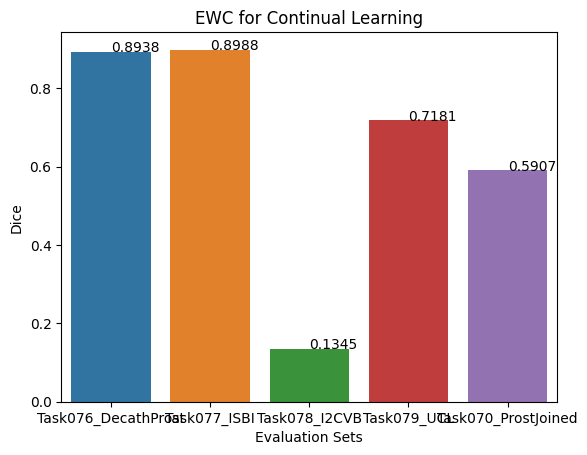

In [12]:
from eval_util import get_dice_vals
import seaborn as sns
import matplotlib.pyplot as plt
eval_folder = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/evaluation/nnUNet_ext/3d_fullres/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/nnUNetTrainerEWC__nnUNetPlansv2.1/Generic_UNet/SEQ/corresponding_head/fold_0/summarized_val_metrics.csv'
tasks = ['Task076_DecathProst', 'Task077_ISBI', 'Task078_I2CVB', 'Task079_UCL', 'Task070_ProstJoined']

tasks, dices = get_dice_vals(tasks, eval_folder)
# Create a bar plot using Seaborn
sns.barplot(x=tasks, y=dices)

# Add labels and title
plt.xlabel('Evaluation Sets')
plt.ylabel('Dice')
for i in range(len(tasks)):
        plt.text(i,dices[i],dices[i])
plt.title('EWC for Continual Learning')

# Show the plot
plt.show()

# Training and Evaluation with Rehearsal
Now we use Rehearsal for training(already done) and evaluate all datasets on the resulting model. It takes approx. 300 seconds:

In [10]:
#nnUNet_train_rehearsal 3d_fullres -t 76 77 78 79 -num_epoch 200 -save_interval 25 -s seg_outputs --store_csv -f 0 -d 0 -samples_in_perc 0.2 Pretrained models are already available in the mounted Google Drive
!nnUNet_evaluate 3d_fullres nnUNetTrainerRehearsal -trained_on 76 77 78 79 -f 0 -use_model 76 77 78 79 -evaluate_on 76 77 78 79 70 -d 0 --store_csv



Please cite the following paper when using nnUNet:

Isensee, F., Jaeger, P.F., Kohl, S.A.A. et al. "nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation." Nat Methods (2020). https://doi.org/10.1038/s41592-020-01008-z


If you have questions or suggestions, feel free to open an issue at https://github.com/MIC-DKFZ/nnUNet

Loading trainer and setting the network for evaluation
2023-10-10 16:05:10.563753: Using dummy2d data augmentation
Updating the Loss based on the provided previous trainer
2023-10-10 16:05:16.744036: loading checkpoint data/results/nnUNet_ext/3d_fullres/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/nnUNetTrainerRehearsal__nnUNetPlansv2.1/Generic_UNet/SEQ/fold_0/model_final_checkpoint.model train= False
/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/nnunet_ext/evaluation/evaluator.py:212: FutureWarning: The frame.append method is deprecated and 

After running this evaluation on the model that was trained using Rehearsal, let's visualize the resulting performance. Note: Task 76/DecathProst is the joint dataset that contains all these datasets.

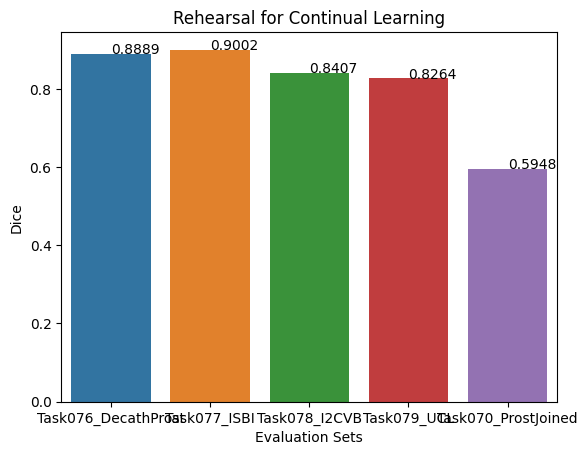

In [13]:
from eval_util import get_dice_vals
import seaborn as sns
import matplotlib.pyplot as plt
eval_folder = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/evaluation/nnUNet_ext/3d_fullres/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/Task076_DecathProst_Task077_ISBI_Task078_I2CVB_Task079_UCL/nnUNetTrainerRehearsal__nnUNetPlansv2.1/Generic_UNet/SEQ/corresponding_head/fold_0/summarized_val_metrics.csv'
tasks = ['Task076_DecathProst', 'Task077_ISBI', 'Task078_I2CVB', 'Task079_UCL', 'Task070_ProstJoined']

tasks, dices = get_dice_vals(tasks, eval_folder)
# Create a bar plot using Seaborn
sns.barplot(x=tasks, y=dices)

# Add labels and title
plt.xlabel('Evaluation Sets')
plt.ylabel('Dice')
for i in range(len(tasks)):
        plt.text(i,dices[i],dices[i])
plt.title('Rehearsal for Continual Learning')

# Show the plot
plt.show()

# Visualization of Training Performance of all Methods
In the following we compare the training performance of all methods during the training process:

/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/cl_plotting


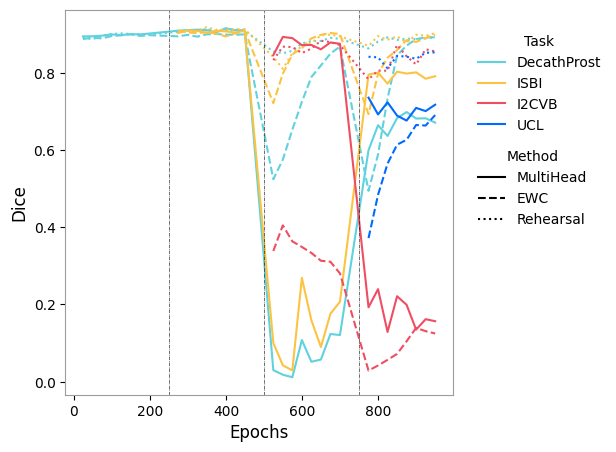

In [14]:
%cd /content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/cl_plotting
from plotting import plot_trajectories
from read_results_utils import cl_methods, dataset_names, task_orderings

path_results = "/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/results"
plots_save_path = '/content/gdrive/MyDrive/PC_Lifelong/cltutorial/Lifelong-nnUNet/data/plots'
anatomy = "prostate"
order = 0
methods = ["nnUNetTrainerMultiHead","nnUNetTrainerEWC", "nnUNetTrainerRehearsal"]

plot_trajectories(path_results, plots_save_path, anatomy, order, methods, endings=[], show=True)